In [1]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

import string
from urllib.parse import urlparse
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing as tfkp
from tensorflow.keras.utils import to_categorical

import gensim.downloader as api
from imblearn.over_sampling import RandomOverSampler

from DL_models import lstm_keras, cnn_keras, blstm, blstm_att

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weetb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def load_data():
    filename = "../data/twitter_data_fixed.pkl"
    print("Loading data from file: " + filename)
    data = pickle.load(open(filename, 'rb'))
    x_text = []
    labels = []
    ids = []
    for i in range(len(data)):
        text = "".join(l for l in data[i]['text'] if l not in string.punctuation)
        x_text.append((data[i]['text']).encode('utf-8'))
        labels.append(data[i]['label'])
    return x_text,labels

In [3]:
def is_url(url):
  try:
    result = urlparse(url)
    return all([result.scheme, result.netloc])
  except ValueError:
    return False

In [4]:
# embedding stuff
def map_weights(embed_dict, vocab, embed_size): # embed size is embedding dim
    vocab_size = len(vocab) + 1
    weights = np.zeros((vocab_size, embed_size))

    n_missed = 0
    words_missed = []
    for k,v in vocab.items():
        try:
            weights[v] = embed_dict[k]  # weights[v] is an index, embed_dict[k] is the list of weights
        except:
            n_missed += 1
            words_missed.append(k)
    print(f"{n_missed} embeddings missed of {vocab_size}")
    return weights, words_missed

### Loading Data

In [5]:
x_text, labels_og = load_data()
labels, uniques = pd.factorize(labels_og)

Loading data from file: ../data/twitter_data_fixed.pkl


### Intitial Twitter-Specific Pre-processing

In [6]:
comments = pd.DataFrame({'comment': x_text, 'attack': labels})

# decode to UTF-8
comments['comment'] = comments['comment'].str.decode("utf-8")

# remove missing rows
comments['comment'].dropna(inplace=True)

# remove usernames
comments['comment'] = comments['comment'].str.replace('(\@\w+.*?)',"", regex=True)

# lower case everything
comments['comment'] = comments['comment'].str.lower()

# remove URLs
comments['comment'] = [' '.join(y for y in x.split() if not is_url(y)) for x in comments['comment']]

# remove stop words
comments['comment'] = comments['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))

# traditionally, would also lemmatize but this was not done in the main data

In [7]:
comments.head()

,comment,attack
0,rt : another bloody instant restaurant week ? ...,0
1,video peshmerga decimating isis far interesting.,0
2,oh really ? instant restaurants ? that's shock...,0
3,rt : good weeks #isis. new front opened #sinja...,0
4,rt : don’t need femisnsn men carry heavy thing...,0


### Train-Test Split and Tokenization

In [8]:
X_train_pretoken, X_midway_pretoken, y_train, y_midway = train_test_split(comments['comment'], comments['attack'], random_state = 42, test_size=0.2)

In [9]:
dim = 25
n_classes = len(np.unique(y_train.values))

tokenizer = tfkp.text.Tokenizer(oov_token="<UNK>", filters='!"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',)
tokenizer.fit_on_texts(X_train_pretoken)

convert = lambda x: tfkp.sequence.pad_sequences(tokenizer.texts_to_sequences(x),
                                                    maxlen=dim,
                                                    padding='post', truncating='post')

X_train = convert(X_train_pretoken)
X_midway = convert(X_midway_pretoken)

In [10]:
X_test, X_val, y_test, y_val = train_test_split(X_midway, y_midway, random_state = 42, test_size=0.5)

### Oversampling

In [11]:
oversample = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

### Reshaping for input

In [12]:
y_train_onehot = to_categorical(y_train, n_classes)
y_val_onehot = to_categorical(y_val, n_classes)
y_test_onehot = to_categorical(y_test, n_classes)
y_train_over_onehot = to_categorical(y_train_over, n_classes)

### Glove Embedding Weights

In [13]:
glove_dict = api.load("glove-twitter-200")
glove_weights, glove_words_missed = map_weights(glove_dict, tokenizer.word_index, 200)

3093 embeddings missed of 15155


### Word2vec Weights

In [14]:
word_dict = api.load("word2vec-google-news-300")
word2vec_weights, word2vec_words_missed = map_weights(word_dict, tokenizer.word_index, 300)

3546 embeddings missed of 15155


#### Checks

In [15]:
# check number of oversampling
from collections import Counter
print(Counter(y_train))
print(Counter(y_train_over))

Counter({0: 8836, 2: 2503, 1: 1533})
Counter({2: 8836, 0: 8836, 1: 8836})


### Write Embedders

In [16]:
from keras.layers import Embedding
from tensorflow.keras import initializers

vocab_size = len(tokenizer.word_index)+1

random_embedder = Embedding(vocab_size, 200, input_length=dim, trainable=True)
glove_embedding = Embedding(vocab_size, 200, input_length=dim, embeddings_initializer=initializers.Constant(glove_weights),
                            trainable=False)
word2vec_embedding = Embedding(vocab_size, 300, input_length=dim, embeddings_initializer=initializers.Constant(word2vec_weights),
                              trainable=False)

### Load DL Models and Run Them

In [28]:
lstm_random = lstm_keras(dim,n_classes,random_embedder)
lstm_random_over = lstm_keras(dim,n_classes,random_embedder)
lstm_glove = lstm_keras(dim,n_classes,glove_embedding)
lstm_glove_over = lstm_keras(dim,n_classes,glove_embedding)
lstm_word2vec = lstm_keras(dim,n_classes,word2vec_embedding)
lstm_word2vec_over = lstm_keras(dim,n_classes,word2vec_embedding)

In [29]:
blstm_random = blstm(dim,n_classes,random_embedder)
blstm_random_over = blstm(dim,n_classes,random_embedder)
blstm_glove = blstm(dim,n_classes,glove_embedding)
blstm_glove_over = blstm(dim,n_classes,glove_embedding)
blstm_word2vec = blstm(dim,n_classes,word2vec_embedding)
blstm_word2vec_over = blstm(dim,n_classes,word2vec_embedding)

In [30]:
blstm_att_random = blstm_att(dim,n_classes,random_embedder)
blstm_att_random_over = blstm_att(dim,n_classes,random_embedder)
blstm_att_glove = blstm_att(dim,n_classes,glove_embedding)
blstm_att_glove_over = blstm_att(dim,n_classes,glove_embedding)
blstm_att_word2vec = blstm_att(dim,n_classes,word2vec_embedding)
blstm_att_word2vec_over = blstm_att(dim,n_classes,word2vec_embedding)

In [31]:
cnn_random = cnn_keras(dim,n_classes,random_embedder)
cnn_random_over = cnn_keras(dim,n_classes,random_embedder)
cnn_glove = cnn_keras(dim,n_classes,glove_embedding)
cnn_glove_over = cnn_keras(dim,n_classes,glove_embedding)
cnn_word2vec = cnn_keras(dim,n_classes,word2vec_embedding)
cnn_word2vec_over = cnn_keras(dim,n_classes,word2vec_embedding)

### Big Blob of Fits

In [ ]:
lstm_random.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_random_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_glove.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_glove_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_word2vec.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_word2vec_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_random.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_random_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_glove.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_glove_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_word2vec.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_word2vec_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_random.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_random_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_glove.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_glove_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_word2vec.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_word2vec_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_random.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_random_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_glove.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_glove_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_word2vec.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_word2vec_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))

In [32]:
model_list = [lstm_random,
lstm_random_over,
lstm_glove,
lstm_glove_over,
lstm_word2vec,
lstm_word2vec_over,
blstm_random,
blstm_random_over,
blstm_glove,
blstm_glove_over,
blstm_word2vec,
blstm_word2vec_over,
blstm_att_random,
blstm_att_random_over,
blstm_att_glove,
blstm_att_glove_over,
blstm_att_word2vec,
blstm_att_word2vec_over,
cnn_random,
cnn_random_over,
cnn_glove,
cnn_glove_over,
cnn_word2vec,
cnn_word2vec_over]

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1087
           1       0.70      0.64      0.66       195
           2       0.61      0.65      0.63       327

    accuracy                           0.77      1609
   macro avg       0.71      0.71      0.71      1609
weighted avg       0.78      0.77      0.77      1609



(array([0.5, 1.5, 2.5]),
 [Text(0.5, 0, '0'), Text(1.5, 0, '1'), Text(2.5, 0, '2')])

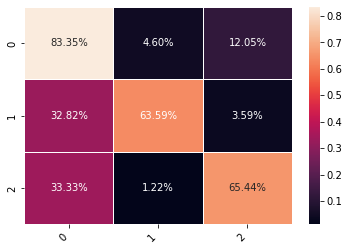

In [27]:
def indiv_eval(model, X_test, y_test, target_names=['Normal', 'Cyberbullying']):
    preds_probs = model.predict(X_test)
    preds = [np.argmax(p) for p in preds_probs]

    print(classification_report(y_test, preds))

    plt.figure()
    sns.heatmap(confusion_matrix(y_test, preds, normalize='true'), fmt='.2%', annot=True ,linewidths=.5,cmap='YlOrRd', annot_kws={"fontsize":10}, yticklabels=target_names, xticklabels=target_names)
    plt.xticks(rotation=45, ha='right')